# RFM Analysis:
***Đặt vấn đề***

RFM là viết tắt của:

**Recency:** Được hiểu là từ lúc mua hàng lần cuối cùng đến hiện tại là bao nhiêu ngày ==> khách hàng càng mua hàng gần đây thì càng dễ gắn kết với thương hiệu hơn so với những người lâu rồi không quay lại mua.

**R (days) = now - last_purchase_date**

**Frequency:** Là tần suất mua hàng

**F = total number of orders**

**Monetary:** Là tổng số tiền khách hàng đã bỏ ra để mua hàng (tổng giá trị các đơn hàng của khách hàng)

**M = total money spent**

Có rất nhiều yếu tố ảnh hưởng đến việc phân loại, mô hình RFM sử dụng 3 yếu tố chính là Recency - Frequency - Monetary để phân nhóm khách hàng

Với bộ số liệu trên tôi sẽ chia thành 3 nhóm dưới đây:

**Nhóm khách hàng có giá trị thấp (Low value):** bao gồm các khách hàng đã lâu rồi chưa quay lại mua, số lượng đơn hàng ít và tổng giá trị đơn hàng thấp

**Nhóm khách hàng có giá trị trung bình (Mid Value):** là nhóm khách hàng có 3 chỉ số RFM trung bình, không cao cũng không thấp

**Nhóm khách hàng có giá trị cao (High Value):** là nhóm khách hàng có mua hàng gần đây, số lượng đơn hàng nhiều và có tộng giá trị cao


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('RetailOnline_analysis.csv')
df.head(5)


,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Year,Month,Day,Hour,WeekDay,revenue
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1,8,Wed,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,Wed,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1,8,Wed,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,Wed,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,Wed,20.34


# Tiền xử lý dữ liệu:

## Chuyển đổi các trường ngày thành đối tượng datetime để xử lý sau này:

In [4]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


## Tạo bảng RFM

In [10]:
snapshot_date = max(df.InvoiceDate) + dt.timedelta(days=1)
# Tạo bảng RFM
rfmTable = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'count',
    'revenue': 'sum'})

# Đổi tên các trường
rfmTable.rename(columns={'InvoiceDate': 'Recency',
                         'Invoice': 'Frequency',
                         'revenue': 'MonetaryValue'}, inplace=True)



## Phân loại các khách hàng thông qua quantile

In [12]:
quantiles = rfmTable.quantile(q=[0.25, 0.5, 0.75])

def RClass(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1
    
def FMClass(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4
    
rfmSegmentation = rfmTable
rfmSegmentation['R_Quartile'] = rfmSegmentation['Recency'].apply(RClass, args=('Recency', quantiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['Frequency'].apply(FMClass, args=('Frequency', quantiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['MonetaryValue'].apply(FMClass, args=('MonetaryValue', quantiles,))


In [16]:
rfmSegmentation

,Recency,Frequency,MonetaryValue,R_Quartile,F_Quartile,M_Quartile,RFMScore,RFM_Level
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,Low Value Customer
12347.0,2,182,4310.00,4,4,4,444,High Value Customer
12348.0,75,31,1797.24,2,2,4,224,Low Value Customer
12349.0,19,73,1757.55,3,3,4,334,Mid Value Customer
12350.0,310,17,334.40,1,1,2,112,Low Value Customer
...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,111,Low Value Customer
18281.0,181,7,80.82,1,1,1,111,Low Value Customer
18282.0,8,12,178.05,4,1,1,411,High Value Customer


## Tính tổng điểm RFM và phân loại khách hàng

In [14]:
rfmSegmentation['RFMScore'] = rfmSegmentation.R_Quartile.map(str) + rfmSegmentation.F_Quartile.map(str) + rfmSegmentation.M_Quartile.map(str)

def rfm_level(df):
    if df['RFMScore'] >= '111' and df['RFMScore'] <= '244':
        return 'Low Value Customer'
    elif df['RFMScore'] >= '245' and df['RFMScore'] <= '344':
        return 'Mid Value Customer'
    elif df['RFMScore'] >= '345' and df['RFMScore'] <= '444':
        return 'High Value Customer'
    
rfmSegmentation['RFM_Level'] = rfmSegmentation.apply(rfm_level, axis=1)


In [17]:
rfmSegmentation

,Recency,Frequency,MonetaryValue,R_Quartile,F_Quartile,M_Quartile,RFMScore,RFM_Level
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,Low Value Customer
12347.0,2,182,4310.00,4,4,4,444,High Value Customer
12348.0,75,31,1797.24,2,2,4,224,Low Value Customer
12349.0,19,73,1757.55,3,3,4,334,Mid Value Customer
12350.0,310,17,334.40,1,1,2,112,Low Value Customer
...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,111,Low Value Customer
18281.0,181,7,80.82,1,1,1,111,Low Value Customer
18282.0,8,12,178.05,4,1,1,411,High Value Customer


## Kết quả

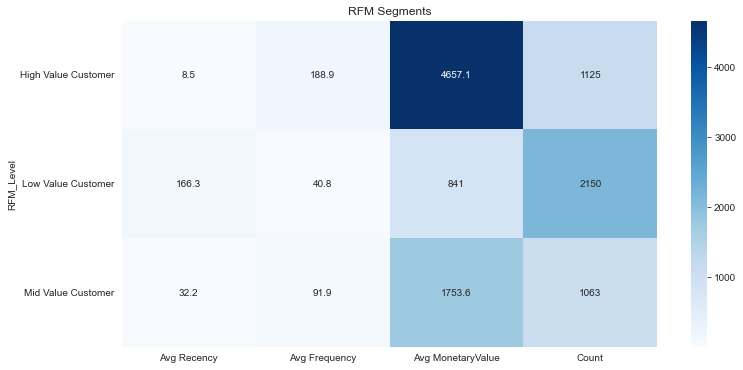

In [15]:

sns.set_style('whitegrid')

# Biểu đồ RFM
rfm_level_agg = rfmSegmentation.groupby(['RFM_Level']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue':['mean','count']}).round(1)

# Đổi tên trường biểu đồ
rfm_level_agg.columns = ['Avg Recency','Avg Frequency','Avg MonetaryValue','Count']

# Hiển thị biểu đồ
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(rfm_level_agg, cmap='Blues', annot=True, fmt='g', ax=ax)
ax.set_title("RFM Segments")
ax.set_yticklabels(rfm_level_agg.index, rotation=0)
plt.show()


Dữ liệu RetailOnline_analysis.csv đã được sử dụng để phân tích RFM bằng Python. RFM (Recency, Frequency, Monetary) là một công cụ quan trọng để phân tích và phân loại khách hàng theo các giá trị, hành vi mua hàng và tần suất mua hàng, giúp doanh nghiệp định hướng chiến lược tiếp thị và tăng cường tương tác với khách hàng.


Dựa trên kết quả phân tích RFM, khách hàng của doanh nghiệp có thể được phân thành các nhóm khách hàng với giá trị thấp, trung bình và cao. Từ đó, doanh nghiệp có thể tập trung vào các chiến lược tiếp thị khác nhau để tăng doanh số bán hàng và tích lũy khách hàng trung thành. Cụ thể:


Nhóm khách hàng có RFM Score cao (345-444) được đánh giá là có giá trị cao trong việc tiếp thị và kinh doanh. Doanh nghiệp có thể tập trung vào việc tăng cường dịch vụ chăm sóc khách hàng và phát triển chiến lược thanh toán linh hoạt để khách hàng trung thành hơn.

Nhóm khách hàng có RFM Score thấp (111-244) có thể cần được giới thiệu thêm các sản phẩm và dịch vụ mới, giảm giá hoặc khuyến mại để tăng cường tương tác và nâng cao giá trị đối với khách hàng này.

Tuy nhiên,để tăng tính hiệu quả của cách tiếp cận phân tích RFM, cần kết hợp thêm với các phương pháp phân tích khác như phân tích đối thủ, phân tích thị trường để đưa ra quyết định kinh doanh chính xác hơn.